In [3]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

cassava_leaf_disease_classification_path = kagglehub.competition_download('cassava-leaf-disease-classification')
abhinand05_vit_base_models_pretrained_pytorch_path = kagglehub.dataset_download('abhinand05/vit-base-models-pretrained-pytorch')
abhinand05_vittutorialillustrations_path = kagglehub.dataset_download('abhinand05/vittutorialillustrations')

print('Data source import complete.')


100%|██████████| 5.76G/5.76G [00:30<00:00, 204MB/s]


Extracting files...


100%|██████████| 1.20G/1.20G [00:06<00:00, 191MB/s]

Extracting files...


100%|██████████| 1.01M/1.01M [00:00<00:00, 124MB/s]

Extracting files...
Data source import complete.


In [5]:
# !cp -r ../input/vittutorialillustrations/* ./

# !pip install nb_black
# %load_ext nb_black

# Introduction

This notebook essentially has two parts as seen from the title.

<a href="#Vision-Transformers:-A-gentle-introduction">1. Vision Transformer: A gentle introduction</a> <br>
<a href="#Vision-Transformer-Implementation-in-PyTorch">2. Implementation in PyTorch</a>

**I'll briefly try to explain the fundamental ideas behind Vision Transformers and how it works before getting into the implementation of ViT in PyTorch for this competition.**

So if you are only interested in code, you can feel free to skip straight ahead to the second section of this notebook. The implementation isn't a whole lot different, thanks to [rwightman/pytorch-image-models](https://github.com/rwightman/pytorch-image-models) library which contains all the model implementations including the pretrained weights for us to use.

# <font size=4 color='blue'>If you find this notebook useful, leave an upvote, that motivates me to write more such notebooks.</font>

# Vision Transformers: A gentle introduction

Vision Transformers were first introduced in the paper [AN IMAGE IS WORTH 16X16 WORDS:
TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://arxiv.org/pdf/2010.11929.pdf) by the Google Brain team in late October 2020.

To understand how ViT works, obviously you must have prior knowledge about how Transformers work and what problems it solved. I'll briefly introduce you to how transformers work before getting into the details of the topic at hand - ViT.

![ViT-Illustration](vision-transformer.png)

If you are new to NLP and interested in learning more about the transformer models and get a fair intuition of how they actually work, I recomment checking out the fantastic blog posts of [Jay Allamar](https://jalammar.github.io/). (The image above was also inspired from one of his blog posts)

## Transformers: A brief overview

> **If you already understand Transformers, feel free to skip ahead to the next section.**

Transformer models well and truly revolutionized Natural Language Processing as we know. When they were first introduced they broke multiple NLP records and were pushing the then State of the Art. Now, they have become a de-facto standard for modern NLP tasks and they bring spectacular performance gains when compared to the previous generation of models like LSTMs and GRUs.  

By far the most important paper that transformed the NLP landscape is the ["Attention is all you need"](https://arxiv.org/pdf/1706.03762.pdf) paper. The transformer architecture was introduced in this paper.

### **Motivations:**

The existing models at that time for sequence and NLP tasks mostly involved RNNs. **The problem with these networks were that they couldn't capture long term dependencies.**

LSTMs and GRUs - variants of RNNs were capable of capturing the dependencies but it is also limited.

So, the main inspiration behind the transformer was to get rid of this recurrence and still end up capturing almost all the dependencies, to be precise global dependencies, yes the reference window of tranformers is full-range. This was achieved using a variant of attention mechanism called *self-attention* (multi-headed) which is very important for their success. One other advantage of Tranformer models are that they are highly parallelizable.  


### Transformer Architecture
**Note: The architecture diagrams are annotated with the corresponding step in the explanation.**

![TranformerArchitecture](transformer-arch.png)

- Transformer has two parts, the decoder which is on the left side on the above diagram and the encoder which is on the right.
- Imagine we are doing machine translation for now.
- The encoder takes the input data (sentence), and produces an intermediate representation of the input.
- The decoder decodes this intermediate representation step by step and generates the output. The difference however is in how it is doing this.
- Understanding the Encoder section is enough for ViT.

> **Note: The explanations here are more about the intuition behind the architectures. For more mathematical details check out the respective research papers instead.**

### Tranformers: Step by step overview
**(1)** The input data first gets embedded into a vector. The embedding layer helps us grab a learned vector representation for each word.

**(2)** In the next stage a positional encoding is injected into the input embeddings. This is because a transformer has no idea about the order of the sequence that is being passed as input - for example a sentence.

**(3)** Now the multi-headed attention is where things get a little different.

**Multi-headed-attention architecture:**
![multi-headed-attn](multi-headed-attention.png)

**(4)** Multi-Headed Attention consists of three learnable vectors. Query, Key and Value vectors. The motivation of this reportedly comes from information retrival where you search (query) and the search engine compares your query with a key and responds with a value.

**(5)** The Q and K representations undergo a dot product matrix multiplication to produce a score matrix which represents how much a word has to attend to every other word. Higher score means more attention and vice-versa.

**(6)** Then the Score matrix is scaled down according to the dimensions of the Q and K vectors. This is to ensure more stable gradients as multiplication can have exploding effects.

(We'll discuss the mask part when we reach the decoder section)

**(7)** Next the Score matrix is softmaxed to turn attention scores into probabilities. Obviously higher scores are heightened and lower scores are depressed. This ensures the model to be confident on which words to attend to.

**(8)** Then the resultant matrix with probabilites is multiplied with the value vector. This will make the higher probaility scores the model has learned to be more important. The low scoring words will effectively drown out to become irrelevant.

**(9)** Then, the concatenated output of QK and V vectors are fed into the Linear layer to process further.

**(10)** Self-Attention is performed for each word in the sequence. Since one doesn't depend on the other a copy of the self attention module can be used to process everything simultaneously making this **multi-headed**.

**(11)** Then the output value vectors are concatenated and added to the residual connection coming from the input layer and then the resultant respresentation is passed into a *LayerNorm* for normalization. (Residual connection help gradients flow through the network and LayernNorm helps reduce the training time by a small fraction and stabilize the network)

**(12)** Further, the output is passed into a point-wise feed forward network to obtain an even richer representation.  

**(13)** The outputs are again Layer-normed and residuals are added from the previous layer.


**Note: This wraps up the encoder section and trust me this is enough to fully understand Vision Transformer. I'll be largely leaving it up to you to understand the decoder part as it is very similar to the encoding layer.**

**(14)** The output from the encoder along with the inputs (if any) from the previous time steps/words are fed into the decoder where the outputs undergo masked-multi headed attention before being fed into the next attention layer along with the output from encoder.

**(15)** Masked multi headed attention is necessary because the network shouldn't have any visibility into the words that are to come later in the sequence while decoding, to ensure there is no leak. This is done by masking the entries of words that come later in the series in the Score matrix. Current and previous words in the sequence are added with 1 and the future word scores are added with `-inf`. This ensures the future words in the series get drowned out into 0 when performing softmax to obtain the probabilities, while the rest are retained.

**(16)** There are residual connections here as well, to improve the flow of gradients. Finally the output is sent to a Linear layer and softmaxed to obtain the outputs in probabilities.

## How Vision Tranformers works?

Now that we have covered transformers' internal working at a high level, we are finally ready to tackle Vision Tranformers.

Applying Transformers on images was always going to be a challenge for the following reasons,
- Unlike words/sentences/paragraphs, images contain much much more information in them basically in form of pixels.
- It would be very hard, even with current hardware to attend to every other pixel in the image.
- Instead, a popular alternative was to use localized attention.
- In fact CNNs do something very similar through convolutions and the receptive field essentially grows bigger as we go deeper into the model's layers, but Tranformers were always going to be computationally more expensive than CNNs because of the' nature of Transformers. And of course, we know how incredibly much CNNs have contributed to the current advancements in Computer Vision.

Google researchers have proposed something different in their paper than can possibly be the next big step in Computer Vision. They show that the reliance on CNNs may not be necessary anymore. So, let's dive right in and explore more about Vision Transformers.


### Vision Transformer Architecture

![vit-architecture](vit-arch.png)

**(1)** They are only using the Encoder part of the transformer but the difference is in how they are feeding the images into the network.

**(2)** They are breaking down the image into fixed size patches. So one of these patches can be of dimension 16x16 or 32x32 as proposed in the paper. More patches means more simpler it is to train these networks as the patches themselves get smaller. Hence we have that in the title - "An Image is worth 16x16 words".

**(3)** The patches are then unrolled (flattened) and sent for further processing into the network.

**(4)** Unlike NNs here the model has no idea whatsoever about the position of the samples in the sequence, here each sample is a patch from the input image. So the image is fed **along with a positional embedding vector** and into the encoder. One thing to note here is the positional embeddings are also learnable so you don't actually feed hard-coded vectors w.r.t to their positions.

**(5)** There is also a special token at the start just like BERT.

**(6)** So each image patch is first unrolled (flattened) into a big vector and gets multiplied with an embedding matrix which is also learnable, creating embedded patches. And these embedded patches are combined with the positional embedding vector and that gets fed into the Tranformer.

> **Note: From here everything is just the same as a standard transformer**

**(7)** With the only difference being, instead of a decoder the output from the encoder is passed directly into a Feed Forward Neural Network to obtain the classification output.

### Things to note:
- The paper ALMOST completely neglects Convolutions.
- They are however using a couple of variants of ViT in which Convolutional embeddings of image patches are used. But that doesn't seem to impact performance much.  
- Vision Transformers, at the time of writing this are topping Image Classification benchmarks on ImageNet.

<img src="benchmarks-chart.png" width="700">
<!-- ![BenchmarksChart](benchmarks-charpng) -->

- There are a lot more interesting things in this paper but the one thing that stands out for me and potentially shows the power of transformers over CNNs is illustrated in the image below which shows the attention distance with respect to the layers.


<img src="attn-distance.png" width="300" height="300">
<br>

- The graph above suggests that the Transformers are already capable of paying attention to  regions that are far apart right from the starting layers of the network which is a pretty significant gain the Transformers bring over CNNs which has a finite receptive field at the start.

# <font size=4 color='blue'>If you find this notebook useful, leave an upvote, that motivates me to write more such notebooks.</font>

## Vision Transformer Implementation in PyTorch
Now that you understand vision transformers, let's build a baseline model for [this competition](https://www.kaggle.com/c/cassava-leaf-disease-classification)

First lets install torch-xla to be able to use the TPU and torch-image-models (timm).

In [6]:
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version 1.7


In [7]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 4.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.9 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.distributed.parallel_loader as pl

import timm

import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics

In [ ]:
# For parallelization in TPUs
# 设置TPU相关环境变量
os.environ["XLA_USE_BF16"] = "1"  # 使用BF16精度
os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"  # 设置张量分配器最大大小

In [ ]:
# 设置随机种子函数,确保结果可复现
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results

    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

In [11]:
cassava_leaf_disease_classification_path

'/root/.cache/kagglehub/competitions/cassava-leaf-disease-classification'

In [12]:
abhinand05_vit_base_models_pretrained_pytorch_path

'/root/.cache/kagglehub/datasets/abhinand05/vit-base-models-pretrained-pytorch/versions/1'

In [13]:
!ls /root/.cache/kagglehub/datasets/abhinand05/vit-base-models-pretrained-pytorch/versions/1

jx_vit_base_p16_224-80ecf9dd.pth  jx_vit_base_p32_384-830016f5.pth
jx_vit_base_p16_384-83fb41ba.pth  jx_vit_base_patch16_384_in21k-0243c7d9.pth


In [14]:
# general global variables
# DATA_PATH = "../input/cassava-leaf-disease-classification"
# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images/"
# TEST_PATH = "../input/cassava-leaf-disease-classification/test_images/"
# MODEL_PATH = (
#     "../input/vit-base-models-pretrained-pytorch/jx_vit_base_p16_224-80ecf9dd.pth"
# )
DATA_PATH = cassava_leaf_disease_classification_path
TRAIN_PATH = cassava_leaf_disease_classification_path + "/train_images/"
TEST_PATH = cassava_leaf_disease_classification_path + "/test_images/"
MODEL_PATH = (
    abhinand05_vit_base_models_pretrained_pytorch_path
    + "/jx_vit_base_p16_224-80ecf9dd.pth"
)

# model specific global variables
IMG_SIZE = 224
BATCH_SIZE = 16
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 5

In [15]:
df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


<Axes: xlabel='label'>

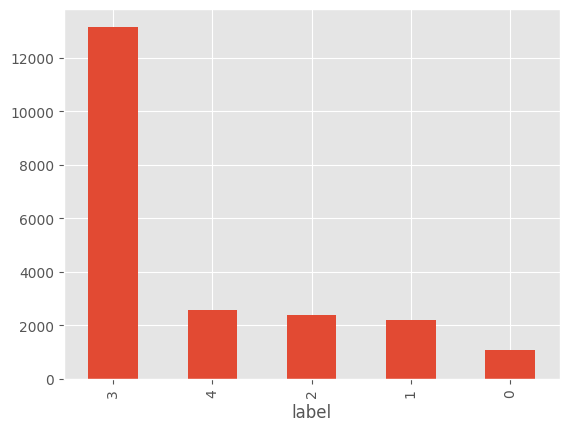

In [17]:
df.label.value_counts().plot(kind="bar")

In [47]:
df = df.sample(frac=0.1).reset_index(drop=True)
train_df, valid_df = model_selection.train_test_split(
    df, test_size=0.1, random_state=42, stratify=df.label.values
)

#减少训练集大小
# train_df = train_df.sample(frac=0.5, random_state=42).reset_index(drop=True)

In [48]:
train_df

,image_id,label
173,1272495783.jpg,0
76,1733354827.jpg,3
50,526290781.jpg,4
195,33304341.jpg,1
29,815702740.jpg,3
...,...,...
54,2905887778.jpg,4
39,2750295170.jpg,3
18,3877043596.jpg,3
64,586687554.jpg,3


In [ ]:
class CassavaDataset(torch.utils.data.Dataset):
    """
    Helper Class to create the pytorch dataset
    自定义数据集类
    参数:
        df: 数据标签DataFrame
        data_path: 数据根目录
        mode: train/test模式
        transforms: 数据增强transforms
    """

    def __init__(self, df, data_path=DATA_PATH, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "train_images" if mode == "train" else "test_images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(img)

        return image, label

In [50]:
# create image augmentations
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [51]:
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

Available Vision Transformer Models: 


['vit_base_mci_224',
 'vit_base_patch8_224',
 'vit_base_patch14_dinov2',
 'vit_base_patch14_reg4_dinov2',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_384',
 'vit_base_patch16_clip_224',
 'vit_base_patch16_clip_384',
 'vit_base_patch16_clip_quickgelu_224',
 'vit_base_patch16_gap_224',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_plus_clip_240',
 'vit_base_patch16_reg4_gap_256',
 'vit_base_patch16_rope_reg1_gap_256',
 'vit_base_patch16_rpn_224',
 'vit_base_patch16_siglip_224',
 'vit_base_patch16_siglip_256',
 'vit_base_patch16_siglip_384',
 'vit_base_patch16_siglip_512',
 'vit_base_patch16_siglip_gap_224',
 'vit_base_patch16_siglip_gap_256',
 'vit_base_patch16_siglip_gap_384',
 'vit_base_patch16_siglip_gap_512',
 'vit_base_patch16_xp_224',
 'vit_base_patch32_224',
 'vit_base_patch32_384',
 'vit_base_patch32_clip_224',
 'vit_base_patch32_clip_256',
 'vit_base_patch32_clip_384',
 'vit_base_patch32_clip_448',
 'vit_base_patch32

In [ ]:
class ViTBase16(nn.Module):
    """
    Vision Transformer实现类
    参数:
        n_classes: 分类数
        pretrained: 是否加载预训练权重
    """

    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()
        # 创建基础ViT模型
        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)
        if pretrained:
            self.model.load_state_dict(torch.load(MODEL_PATH))
        # 修改分类头
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # keep track of training loss
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        ###################
        # train the model #
        ###################
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.forward(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Calculate Accuracy
            accuracy = (output.argmax(dim=1) == target).float().mean()
            # update training loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy

            # perform a single optimization step (parameter update)
            if device.type == "xla":
                xm.optimizer_step(optimizer)

                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                optimizer.step()

        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # keep track of validation loss
        valid_loss = 0.0
        valid_accuracy = 0.0

        ######################
        # validate the model #
        ######################
        self.model.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            with torch.no_grad():
                # forward pass: compute predicted outputs by passing inputs to the model
                output = self.model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # Calculate Accuracy
                accuracy = (output.argmax(dim=1) == target).float().mean()
                # update average validation loss and accuracy
                valid_loss += loss
                valid_accuracy += accuracy

        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [53]:
def fit_tpu(
    model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
):

    # valid_loss_min = np.Inf  # track change in validation loss
    # Use np.inf instead of np.Inf
    valid_loss_min = np.inf

    # keeping track of losses as it happen
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        para_train_loader = pl.ParallelLoader(train_loader, [device])

        xm.master_print(f"{'='*50}")
        xm.master_print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(
            para_train_loader.per_device_loader(device), criterion, optimizer, device
        )
        xm.master_print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        if valid_loader is not None:
            gc.collect()
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            xm.master_print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(
                para_valid_loader.per_device_loader(device), criterion, device
            )
            xm.master_print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            # save model if validation loss has decreased
            if valid_loss <= valid_loss_min and epoch != 1:
                xm.master_print(
                    "Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...".format(
                        valid_loss_min, valid_loss
                    )
                )
            #                 xm.save(model.state_dict(), 'best_model.pth')

            valid_loss_min = valid_loss

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

In [54]:
model = ViTBase16(n_classes=5, pretrained=True)

In [ ]:
def _run():
    """
    主训练函数
    - 创建数据加载器
    - 设置损失函数和优化器
    - 执行训练循环
    - 保存模型
    """
    train_dataset = CassavaDataset(train_df, transforms=transforms_train)
    valid_dataset = CassavaDataset(valid_df, transforms=transforms_valid)

    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True,
    )

    valid_sampler = torch.utils.data.distributed.DistributedSampler(
        valid_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False,
    )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        drop_last=True,
        num_workers=8,
    )

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_sampler,
        drop_last=True,
        num_workers=8,
    )

    criterion = nn.CrossEntropyLoss()
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = xm.xla_device()
    model.to(device)

    lr = LR * xm.xrt_world_size()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xm.master_print(f"INITIALIZING TRAINING ON {xm.xrt_world_size()} TPU CORES")
    start_time = datetime.now()
    xm.master_print(f"Start Time: {start_time}")

    logs = fit_tpu(
        model=model,
        epochs=N_EPOCHS,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )

    xm.master_print(f"Execution time: {datetime.now() - start_time}")

    xm.master_print("Saving Model")
    xm.save(
        model.state_dict(), f'model_5e_{datetime.now().strftime("%Y%m%d-%H%M")}.pth'
    )

In [58]:
# Start training processes
def _mp_fn(rank, flags):
    torch.set_default_tensor_type("torch.FloatTensor")
    # a = _run()

    # Make sure the model is created inside each process
    # This ensures each process has its own copy of the model on the correct device
    # global model  # Access the global model variable
    # model = ViTBase16(n_classes=5, pretrained=True)
    # device = xm.xla_device()
    # model.to(device)
    a = _run()


# _run()
FLAGS = {}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=1, start_method="fork")

/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


INITIALIZING TRAINING ON 1 TPU CORES
Start Time: 2025-05-12 07:28:44.232182
EPOCH 1 - TRAINING...
	BATCH 1/12 - LOSS: 1.9375

	[TRAIN] EPOCH 1 - LOSS: 1.8828125, ACCURACY: 0.140625

EPOCH 1 - VALIDATING...
EPOCH 1 - VALIDATING...	[VALID] LOSS: 1.734375, ACCURACY: 0.1875

EPOCH 2 - TRAINING...
EPOCH 2 - TRAINING...
	BATCH 1/12 - LOSS: 1.5625

	[TRAIN] EPOCH 2 - LOSS: 1.625, ACCURACY: 0.265625

EPOCH 2 - VALIDATING...
	[VALID] LOSS: 1.5390625, ACCURACY: 0.375

Validation loss decreased (1.7344 --> 1.5391).  Saving model ...
EPOCH 3 - TRAINING...
EPOCH 3 - TRAINING...
	BATCH 1/12 - LOSS: 1.375

	[TRAIN] EPOCH 3 - LOSS: 1.4609375, ACCURACY: 0.443359375

EPOCH 3 - VALIDATING...
EPOCH 3 - VALIDATING...
	[VALID] LOSS: 1.3984375, ACCURACY: 0.5

Validation loss decreased (1.5391 --> 1.3984).  Saving model ...
EPOCH 4 - TRAINING...
EPOCH 4 - TRAINING...
	BATCH 1/12 - LOSS: 1.2578125

	[TRAIN] EPOCH 4 - LOSS: 1.328125, ACCURACY: 0.50390625

EPOCH 4 - VALIDATING...
	[VALID] LOSS: 1.3125, ACCURACY:

## Thanks a lot for reading all the way

# <font size=4 color='blue'>If you find this notebook useful, leave an upvote, that motivates me to write more such notebooks.</font>